# SageMaker Inference Recommender - CloudWatch Metrics

## 1. Introduction

SageMaker Inference Recommender is a new capability of SageMaker that reduces the time required to get machine learning (ML) models in production by automating load tests and optimizing model performance across instance types. You can use Inference Recommender to select a real-time inference endpoint that delivers the best performance at the lowest cost. 

Get started with Inference Recommender on SageMaker in minutes while selecting an instance and get an optimized endpoint configuration in hours, eliminating weeks of manual testing and tuning time.

In this notebook, we will walk you through getting recommendations for a TensorFlow model and using information from Inference Recommender to pull additional metrics from CloudWatch.

## 2. Setup 

Note that we are using the `conda_tensorflow_p36` kernel in SageMaker Notebook Instances. This is running Python 3.6 and TensorFlow 1.15.5. If you'd like to use the same setup, in the AWS Management Console, go to the Amazon SageMaker console. Choose Notebook Instances, and click create a new notebook instance. Upload the current notebook and set the kernel. You can also run this in SageMaker Studio Notebooks with the `TensorFlow 1.15 Python 3.6 CPU Optimized` kernel.

In the next steps, you'll import standard methods and libraries as well as set variables that will be used in this notebook. The `get_execution_role` function retrieves the AWS Identity and Access Management (IAM) role you created at the time of creating your notebook instance.

In [1]:
from sagemaker import get_execution_role, Session, image_uris
import boto3
import time

In [2]:
region = boto3.Session().region_name
role = get_execution_role()
sm_client = boto3.client("sagemaker", region_name=region)
sagemaker_session = Session()
print(region)

us-east-2


## 3. Machine learning model details

Inference Recommender uses metadata about your ML model to recommend the best instance types and endpoint configurations for deployment. You can provide as much or as little information as you'd like but the more information you provide, the better your recommendations will be.

ML Frameworks: `TENSORFLOW, PYTORCH, XGBOOST, SAGEMAKER-SCIKIT-LEARN`

ML Domains: `COMPUTER_VISION, NATURAL_LANGUAGE_PROCESSING, MACHINE_LEARNING`

Example ML Tasks: `CLASSIFICATION, REGRESSION, IMAGE_CLASSIFICATION, OBJECT_DETECTION, SEGMENTATION, MASK_FILL, TEXT_CLASSIFICATION, TEXT_GENERATION, OTHER`

In [6]:
import tensorflow as tf

# ML framework details
framework = "tensorflow"
framework_version = tf.__version__

# model name as standardized by model zoos or a similar open source model
model_name = "resnet50"

# ML model details
ml_domain = "COMPUTER_VISION"
ml_task = "IMAGE_CLASSIFICATION"

print("TF Version", framework_version)


TF Version 1.15.5


## 4. Create a model archive

SageMaker models need to be packaged in `.tar.gz` files. When your SageMaker Endpoint is provisioned, the files in the archive will be extracted and put in `/opt/ml/model/` on the Endpoint. 

In this step, there are two optional tasks to:

   (1) Download a pretrained model from Keras applications
   
   (2) Download a sample inference script (inference.py) from S3
   
These tasks are provided as a sample reference but can and should be modified when using your own trained models with Inference Recommender. 

### Optional: Download model from Keras applications

Let's download the model from Keras applications. By setting the variable download_the_model=False, you can skip the download and provide your own model archive.

In [7]:
download_the_model = True

In [8]:
import os
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import backend

if download_the_model:
    tf.keras.backend.set_learning_phase(0)
    model = tf.keras.applications.ResNet50()

    # Creating the directory strcture
    model_version = "1"
    export_dir = "./model/" + model_version
    if not os.path.exists(export_dir):
        os.makedirs(export_dir)
        print("Directory ", export_dir, " Created ")
    else:
        print("Directory ", export_dir, " already exists")
    # Save to SavedModel
    model.save(export_dir, save_format="tf", include_optimizer=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
102973440/102967424 [==============================] - 1s 0us/step
Directory  ./model/1  Created 
INFO:tensorflow:Assets written to: ./model/1/assets


### Create a tarball

To bring your own TensorFlow model, SageMaker expects a single archive file in .tar.gz format, containing a model file (\*.pb) in TF SavedModel format and the script (\*.py) for inference.

In [9]:
model_archive_name = "tf-model.tar.gz"

In [10]:
!tar -cvpzf {model_archive_name} ./model ./code

./model/
./model/1/
./model/1/variables/
./model/1/variables/variables.data-00001-of-00002
./model/1/variables/variables.data-00000-of-00002
./model/1/variables/variables.index
./model/1/saved_model.pb
./model/1/assets/
./code/
./code/requirements.txt
./code/inference.py


### Upload to S3

We now have a model archive ready. We need to upload it to S3 before we can use with Inference Recommender. Furthermore, we will use the SageMaker Python SDK to handle the upload.

In [11]:
# model package tarball (model artifact + inference code)
model_url = sagemaker_session.upload_data(path=model_archive_name, key_prefix="model")
print("model uploaded to: {}".format(model_url))

model uploaded to: s3://sagemaker-us-east-2-156991241640/model/tf-model.tar.gz


### Optional: Model optimization

[Amazon SageMaker Neo](https://aws.amazon.com/sagemaker/neo) is a capability of SageMaker that automatically optimizes your ML models for any target instance type. With Neo, you don’t need to set up third-party or framework-specific compiler software, or tune the model manually for optimizing inference performance. 

Inference Recommender compiles your model using SageMaker Neo if the `ModelInput` field is provided. To prepare the inputs for model compilation, specify the input layer name and shape (NHWC format for TF) for your trained model. The dictionary format required is as follows:

    For one input: {'input':[1,1024,1024,3]}

In [12]:
data_input_configuration = '{"input_1":[1,3,224,224]}'

If you don't know your input layer name or shape, you can use the `saved_model_cli`. [Learn more](https://www.tensorflow.org/guide/saved_model)

In [14]:
!pip install --quiet tensorflow-serving-api

You can see below that the input layer name is `'input_1'` and the input shape is `(-1, 224, 224, 3)`. SageMaker Neo expects a static input shape so we change `-1` to `1` to indicate a batch size of 1.

In [15]:
!saved_model_cli show --dir {export_dir} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['probs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1000)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Defined Functions:
  Function Name: '__call__'


## 5. Create a sample payload archive

We need to create an archive that contains individual files that Inference Recommender can send to your  Endpoint. Inference Recommender will randomly sample files from this archive so make sure it contains a similar distribution of payloads you'd expect in production. Note that your inference code must be able to read in the file formats from the sample payload.

*Here we are only adding only four images for the example. In your own use case(s), it's recommended to add a variety of samples that is representative of your payloads.* 

In [16]:
payload_archive_name = "payload.tar.gz"

In [17]:
## optional: download sample images
SAMPLES_BUCKET = "sagemaker-sample-files"
PREFIX = "datasets/image/pets/"
payload_location = "./sample-payload/"

if not os.path.exists(payload_location):
    os.makedirs(payload_location)
    print("Directory ", payload_location, " Created ")
else:
    print("Directory ", payload_location, " already exists")

sagemaker_session.download_data(payload_location, SAMPLES_BUCKET, PREFIX)

Directory  ./sample-payload/  Created 


### Create a tarball

In [36]:
!cd ./sample-payload/ && tar czvf ../payload.tar.gz * #!tar -czvf {payload_archive_name} -C {payload_location} .

boxer_dog.jpg
british_blue_shorthair_cat.jpg
english_cocker_spaniel_dog.jpg
shiba_inu_dog.jpg


### Upload to S3

Next, we'll upload the packaged payload examples (payload.tar.gz) that was created above to S3.  The S3 location will be used as input to our Inference Recommender job later in this notebook. 

In [37]:
sample_payload_url = sagemaker_session.upload_data(path=payload_archive_name, key_prefix="payload")

## 6. Register model in Model Registry

In order to use Inference Recommender, you must have a versioned model in SageMaker Model Registry.  To register a model in the Model Registry, you must have a model artifact packaged in a tarball and an inference container image.  Registering a model includes the following steps:


1) **Create Model Group:** This is a one-time task per machine learning use case. A Model Group contains one or more versions of your packaged model. 

2) **Register Model Version/Package:** This task is performed for each new packaged model version. 

### Container image URL

If you don’t have an inference container image, you can use one of the open source AWS [Deep Learning Containers (DLCs)](https://github.com/aws/deep-learning-containers) provided by AWS to serve your ML model. The code below retrieves a DLC based on your ML framework, framework version, python version, and instance type.

In [38]:
instance_type = "ml.c5.xlarge"  # Note: you can use any CPU-based instance type here, this is just to get a CPU tagged image
dlc_uri = image_uris.retrieve(
    framework,
    region,
    version=framework_version,
    py_version="py3",
    instance_type=instance_type,
    image_scope="inference",
)
dlc_uri

'763104351884.dkr.ecr.us-east-2.amazonaws.com/tensorflow-inference:1.15.5-cpu'

### Create Model Group

In [39]:
model_package_group_name = "{}-cpu-models-".format(framework) + str(round(time.time()))
model_package_group_description = "{} models".format(ml_task.lower())

model_package_group_input_dict = {
    "ModelPackageGroupName": model_package_group_name,
    "ModelPackageGroupDescription": model_package_group_description,
}

create_model_package_group_response = sm_client.create_model_package_group(
    **model_package_group_input_dict
)
print(
    "ModelPackageGroup Arn : {}".format(create_model_package_group_response["ModelPackageGroupArn"])
)

ModelPackageGroup Arn : arn:aws:sagemaker:us-east-2:156991241640:model-package-group/tensorflow-cpu-models-1641422569


### Register Model Version/Package

In this step, you'll register your pretrained model that was packaged in the prior steps as a new version in SageMaker Model Registry.  First, you'll configure the model package/version identifying which model package group this new model should be registered within as well as identify the initial approval status. You'll also identify the domain and task for your model.  These values were set earlier in the notebook 
where `ml_domain = 'COMPUTER_VISION'` and `ml_task = 'IMAGE_CLASSIFICATION'`

*Note: ModelApprovalStatus is a configuration parameter that can be used in conjunction with SageMaker Projects to trigger automated deployment pipeline.*  

In [40]:
model_package_description = "{} {} inference recommender".format(framework, model_name)

model_approval_status = "PendingManualApproval"

create_model_package_input_dict = {
    "ModelPackageGroupName": model_package_group_name,
    "Domain": ml_domain.upper(),
    "Task": ml_task.upper(),
    "SamplePayloadUrl": sample_payload_url,
    "ModelPackageDescription": model_package_description,
    "ModelApprovalStatus": model_approval_status,
}

### Set up inference specification

You'll now setup the inference specification configuration for your model version.  This contains information on how the model should be hosted.

Inference Recommender expects a single input MIME type for sending requests. Learn more about [common inference data formats on SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-inference.html). This MIME type will be sent in the Content-Type header when invoking your endpoint.

In [41]:
input_mime_types = ["application/x-image"]

If you specify a set of instance types below (i.e. non-empty list), then Inference Recommender will only support recommendations within the set of instances below. For this example, we provide a list of common instance types used for image classification algorithms.

In [42]:
supported_realtime_inference_types = [
    "ml.c5.xlarge",
    "ml.m5.xlarge",
    "ml.c5d.large",
    "ml.g4dn.xlarge",
    "ml.m5.large",
    "ml.inf1.xlarge",
    "ml.inf1.6xlarge",
]

In [43]:
modelpackage_inference_specification = {
    "InferenceSpecification": {
        "Containers": [
            {
                "Image": dlc_uri,
                "Framework": framework.upper(),
                "FrameworkVersion": framework_version,
                "NearestModelName": model_name,
                "ModelInput": {"DataInputConfig": data_input_configuration},
            }
        ],
        "SupportedContentTypes": input_mime_types,  # required, must be non-null
        "SupportedResponseMIMETypes": [],
        "SupportedRealtimeInferenceInstanceTypes": supported_realtime_inference_types,  # optional
    }
}

# Specify the model data
modelpackage_inference_specification["InferenceSpecification"]["Containers"][0][
    "ModelDataUrl"
] = model_url

Now that you've configured the model package, the next step is to create the model package/version in SageMaker Model Registry

In [44]:
create_model_package_input_dict.update(modelpackage_inference_specification)

In [45]:
create_mode_package_response = sm_client.create_model_package(**create_model_package_input_dict)
model_package_arn = create_mode_package_response["ModelPackageArn"]
print("ModelPackage Version ARN : {}".format(model_package_arn))

ModelPackage Version ARN : arn:aws:sagemaker:us-east-2:156991241640:model-package/tensorflow-cpu-models-1641422569/1


## 7. Create an Inference Recommender Default Job

Now with your model in Model Registry, you can kick off a 'Default' job to get instance recommendations. This only requires your `ModelPackageVersionArn` and comes back with recommendations within 45 minutes.

The output is a list of instance type recommendations with associated environment variables, cost, throughput and latency metrics.

In [46]:
default_job_name = model_name + "-instance-" + str(round(time.time()))
job_description = "{} {}".format(framework, model_name)
job_type = "Default"
print("job_name:", default_job_name)

job_name: resnet50-instance-1641422577


In [47]:
rv = sm_client.create_inference_recommendations_job(
    JobName=default_job_name,
    JobDescription=job_description,  # optional
    JobType=job_type,
    RoleArn=role,
    InputConfig={"ModelPackageVersionArn": model_package_arn},
)

print(rv)

{'JobArn': 'arn:aws:sagemaker:us-east-2:156991241640:inference-recommendations-job/resnet50-instance-1641422577', 'ResponseMetadata': {'RequestId': '16190b2f-49c3-4c46-a43b-d23b91e247ea', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '16190b2f-49c3-4c46-a43b-d23b91e247ea', 'content-type': 'application/x-amz-json-1.1', 'content-length': '112', 'date': 'Wed, 05 Jan 2022 22:42:58 GMT'}, 'RetryAttempts': 0}}


## 8. Instance Recommendation Results

Each inference recommendation includes `InstanceType`, `InitialInstanceCount`, `EnvironmentParameters` which are tuned environment variable parameters for better performance. We also include performance and cost metrics such as `MaxInvocations`, `ModelLatency`, `CostPerHour` and `CostPerInference`. We believe these metrics will help you narrow down to a specific endpoint configuration that suits your use case. 

Example:   

If your motivation is overall price-performance with an emphasis on throughput, then you should focus on `CostPerInference` metrics  
If your motivation is a balance between latency and throughput, then you should focus on `ModelLatency` / `MaxInvocations` metrics

| Metric | Description |
| --- | --- |
| ModelLatency | The interval of time taken by a model to respond as viewed from SageMaker. This interval includes the local communication times taken to send the request and to fetch the response from the container of a model and the time taken to complete the inference in the container. <br /> Units: Microseconds |
| MaximumInvocations | The maximum number of InvokeEndpoint requests sent to a model endpoint. <br /> Units: None |
| CostPerHour | The estimated cost per hour for your real-time endpoint. <br /> Units: US Dollars |
| CostPerInference | The estimated cost per inference for your real-time endpoint. <br /> Units: US Dollars |

In [48]:
import pprint
import pandas as pd

finished = False
while not finished:
    inference_recommender_job = sm_client.describe_inference_recommendations_job(
        JobName=default_job_name
    )
    if inference_recommender_job["Status"] in ["COMPLETED", "STOPPED", "FAILED"]:
        finished = True
    else:
        print("In progress")
        time.sleep(300)

if inference_recommender_job["Status"] == "FAILED":
    print("Inference recommender job failed ")
    print("Failed Reason: {}".format(inference_recommender_job["FailureReason"]))
else:
    print("Inference recommender job completed")

In progress
In progress
In progress
In progress
In progress
In progress
Inference recommender job completed


In [49]:
data = [
    {**x["EndpointConfiguration"], **x["ModelConfiguration"], **x["Metrics"]}
    for x in inference_recommender_job["InferenceRecommendations"]
]
df = pd.DataFrame(data)
df.drop("VariantName", inplace=True, axis=1)
pd.set_option("max_colwidth", 400)
df.head()

,EndpointName,InstanceType,InitialInstanceCount,EnvironmentParameters,CostPerHour,CostPerInference,MaxInvocations,ModelLatency
0,sm-epc-40382cf8-366c-4afe-8e9a-71b4078aa324,ml.c5.xlarge,1,"[{'Key': 'TS_DEFAULT_WORKERS_PER_MODEL', 'ValueType': 'string', 'Value': '1'}, {'Key': 'OMP_NUM_THREADS', 'ValueType': 'string', 'Value': '1'}]",0.204,0.000007,508,3674
1,sm-epc-3f305512-d852-47cc-9745-e3f740dcc0ab,ml.c5d.large,1,"[{'Key': 'TS_DEFAULT_WORKERS_PER_MODEL', 'ValueType': 'string', 'Value': '16'}, {'Key': 'OMP_NUM_THREADS', 'ValueType': 'string', 'Value': '1'}]",0.115,0.000005,396,524
2,sm-epc-c9bf5366-42b7-49d3-bf69-74dfbacc5c8e,ml.m5.xlarge,1,"[{'Key': 'TS_DEFAULT_WORKERS_PER_MODEL', 'ValueType': 'string', 'Value': '32'}, {'Key': 'OMP_NUM_THREADS', 'ValueType': 'string', 'Value': '1'}]",0.230,0.000007,536,1987
3,sm-epc-17652a73-ec0c-405c-b7e1-ef9bdcae0e1a,ml.m5.large,1,"[{'Key': 'TS_DEFAULT_WORKERS_PER_MODEL', 'ValueType': 'string', 'Value': '2'}, {'Key': 'OMP_NUM_THREADS', 'ValueType': 'string', 'Value': '1'}]",0.115,0.000006,297,2431


## 9. Custom Load Test

With an 'Advanced' job, you can provide your production requirements, select instance types, tune environment variables and perform more extensive load tests. This typically takes 2 hours depending on your traffic pattern and number of instance types. 

The output is a list of endpoint configuration recommendations (instance type, instance count, environment variables) with associated cost, throughput and latency metrics.

In the below example, we are tuning the endpoint against an environment variable `OMP_NUM_THREADS` with three values `[2, 4, 10]` and we aim to have a 95th percentile latency to be no more than `100` ms. 

In [50]:
job_type = "Advanced"
advanced_job_name = (
    model_name + "-" + instance_type.replace(".", "-") + "-load-test-" + str(round(time.time()))
)
advanced_job_description = "{} {} on {}".format(framework, model_name, instance_type)

### Instance configurations

In [51]:
instance_type = "ml.m5.xlarge"

In [52]:
env_parameter_ranges = [{"Name": "OMP_NUM_THREADS", "Value": ["2", "4", "10"]}]

### Stopping conditions

In [53]:
# P95 latency (ms)
p95_model_latency = 100
# throughput
max_invocations = 300

### Traffic pattern

In [54]:
traffic_pattern_phases = [{"InitialNumberOfUsers": 1, "SpawnRate": 1, "DurationInSeconds": 120}]

### Resource limits

In [55]:
# total duration of Advanced job in seconds
job_duration = 7200
# Total number of endpoint configuration should be less than or equal to MaxNumberOfTests
max_number_of_tests = 10
max_parallel_tests = 1

In [56]:
advanced_response = sm_client.create_inference_recommendations_job(
    JobName=advanced_job_name,
    JobDescription=advanced_job_description,
    JobType=job_type,
    RoleArn=role,
    InputConfig={
        "ModelPackageVersionArn": model_package_arn,
        "JobDurationInSeconds": job_duration,
        "EndpointConfigurations": [
            {
                "InstanceType": instance_type,
                "EnvironmentParameterRanges": {"CategoricalParameterRanges": env_parameter_ranges},
            }
        ],
        "ResourceLimit": {
            "MaxNumberOfTests": max_number_of_tests,
            "MaxParallelOfTests": max_parallel_tests,
        },
        "TrafficPattern": {"TrafficType": "PHASES", "Phases": traffic_pattern_phases},
    },
    StoppingConditions={
        "MaxInvocations": max_invocations,
        "ModelLatencyThresholds": [{"Percentile": "P95", "ValueInMilliseconds": p95_model_latency}],
    },
)

print(advanced_response)

{'JobArn': 'arn:aws:sagemaker:us-east-2:156991241640:inference-recommendations-job/resnet50-ml-c5-xlarge-load-test-1641425849', 'ResponseMetadata': {'RequestId': '89fd64c4-4d64-4d76-a54c-8f353645e9d4', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '89fd64c4-4d64-4d76-a54c-8f353645e9d4', 'content-type': 'application/x-amz-json-1.1', 'content-length': '126', 'date': 'Wed, 05 Jan 2022 23:37:38 GMT'}, 'RetryAttempts': 0}}


## 10. Custom Load Test Results

Inference recommender does benchmarking on both the endpoint configurations and here is the result. 

Analyzing load test result,    
`OMP_NUM_THREADS` = 2 shows ~20% better throughput when compared to `OMP_NUM_THREADS` = 4   
`OMP_NUM_THREADS` = 2 shows 25% saving in inference-cost when compared to `OMP_NUM_THREADS` = 4   

In all front, `OMP_NUM_THREADS` = 2  is much better endpoint configuration than `OMP_NUM_THREADS` = 4 

In [58]:
finished = False
while not finished:
    inference_recommender_job = sm_client.describe_inference_recommendations_job(
        JobName=advanced_job_name
    )
    if inference_recommender_job["Status"] in ["COMPLETED", "STOPPED", "FAILED"]:
        finished = True
    else:
        print("In progress")
        time.sleep(300)

if inference_recommender_job["Status"] == "FAILED":
    print("Inference recommender job failed")
    print("Failure Reason: {}".format(inference_recommender_job["FailureReason"]))
else:
    print("Inference recommender job completed")

In progress
In progress
In progress
Inference recommender job completed


In [59]:
data = [
    {**x["EndpointConfiguration"], **x["ModelConfiguration"], **x["Metrics"]}
    for x in inference_recommender_job["InferenceRecommendations"]
]
df = pd.DataFrame(data)
df.drop("VariantName", inplace=True, axis=1)
pd.set_option("max_colwidth", 400)
df.head()

,EndpointName,InstanceType,InitialInstanceCount,EnvironmentParameters,CostPerHour,CostPerInference,MaxInvocations,ModelLatency
0,sm-epc-ba95ed0b-e033-434a-a87a-f4576676e33b,ml.m5.xlarge,3,"[{'Key': 'OMP_NUM_THREADS', 'ValueType': 'string', 'Value': '4'}]",0.69,0.000030,387,100
1,sm-epc-58a0df25-ca81-4c92-853f-809380037181,ml.m5.xlarge,2,"[{'Key': 'OMP_NUM_THREADS', 'ValueType': 'string', 'Value': '2'}]",0.46,0.000015,522,100
2,sm-epc-063eedac-0fcb-4e80-9cc6-ccab01aec252,ml.m5.xlarge,5,"[{'Key': 'OMP_NUM_THREADS', 'ValueType': 'string', 'Value': '10'}]",1.15,0.000064,300,100


## 11. Review detailed CloudWatch metrics

Below we've provided a helper script cloudwatch.py that you can import to get access to functions for reviewing CW metrics. Just by providing your region and Inference Recommender job name you can get detailed charts of your endpoints during the load test.

| Metric | Description |
| --- | --- |
| OverheadLatency | The interval of time added to the time taken to respond to a client request by SageMaker overheads. This interval is measured from the time SageMaker receives the request until it returns a response to the client, minus the ModelLatency. Overhead latency can vary depending on multiple factors, including request and response payload sizes, request frequency, and authentication/authorization of the request. <br /> Units: Microseconds |
| CPUUtilization | The sum of each individual CPU core's utilization. The CPU utilization of each core range is 0–100. For example, if there are four CPUs, the CPUUtilization range is 0%–400%. For processing jobs, the value is the CPU utilization of the processing container on the instance. <br /> For training jobs, the value is the CPU utilization of the algorithm container on the instance. <br /> For batch transform jobs, the value is the CPU utilization of the transform container on the instance. <br /> For endpoint variants, the value is the sum of the CPU utilization of the primary and supplementary containers on the instance. <br /> Note: <br /> For multi-instance jobs, each instance reports CPU utilization metrics. However, the default view in CloudWatch shows the average CPU utilization across all instances. <br /> Units: Percent |
| MemoryUtilization | The percentage of memory that is used by the containers on an instance. This value range is 0%–100%. <br /> For processing jobs, the value is the memory utilization of the processing container on the instance. <br /> For training jobs, the value is the memory utilization of the algorithm container on the instance. <br /> For batch transform jobs, the value is the memory utilization of the transform container on the instance. <br /> For endpoint variants, the value is the sum of the memory utilization of the primary and supplementary containers on the instance. <br /> Units: Percent |

Learn more about CloudWatch: https://docs.aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html

In [3]:
from cloudwatch import get_endpoint_metrics

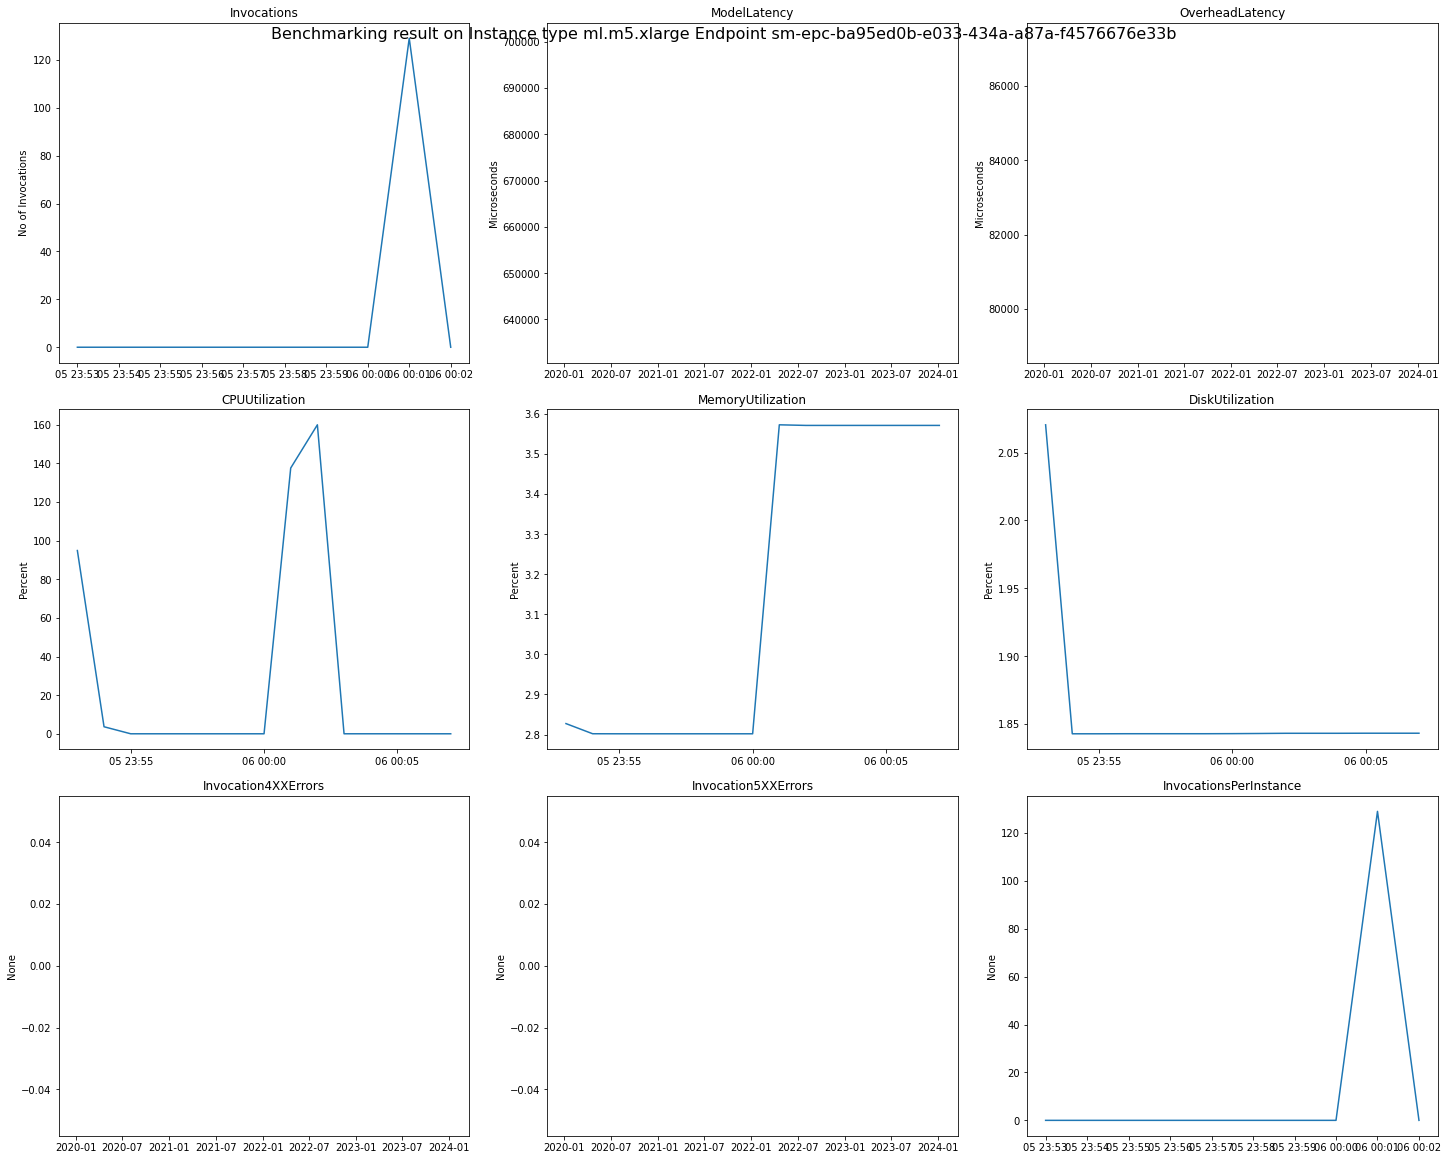

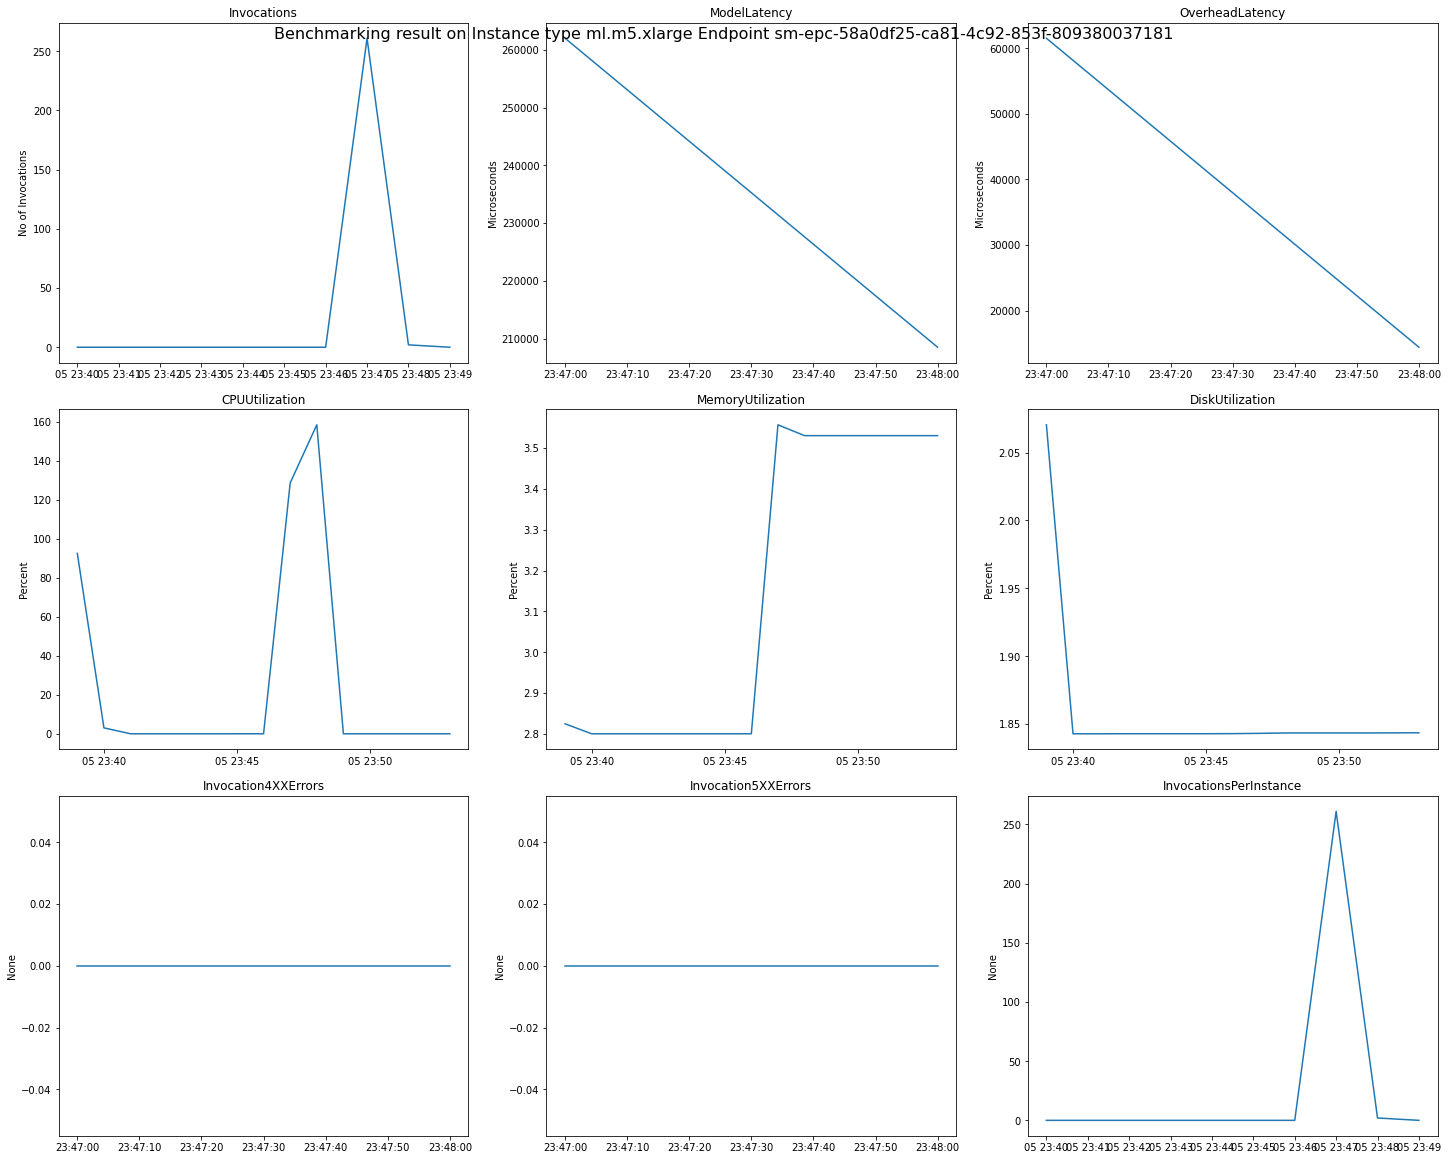

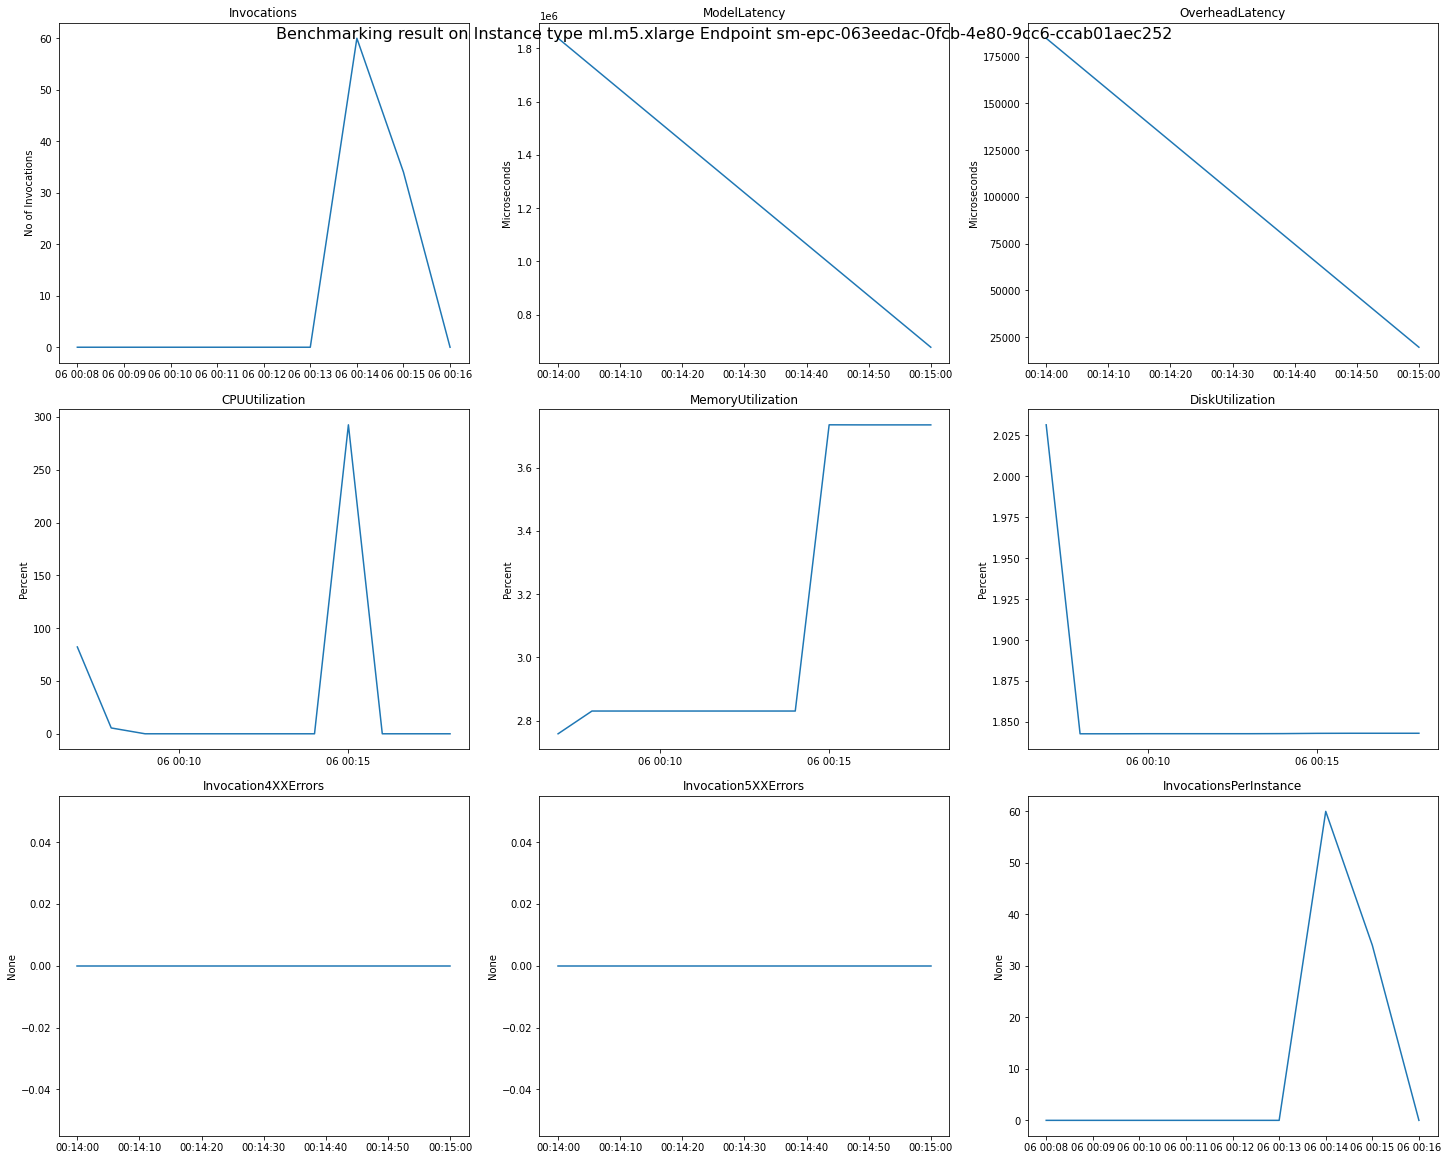

In [5]:
cw_client = boto3.client('cloudwatch', region)
df_cw = get_endpoint_metrics(sm_client, cw_client, region, advanced_job_name, include_plots=True)

## 9. Conclusion

This notebook discussed how to use SageMaker Inference Recommender with a TensorFlow model to help determine the right CPU instance type, instance count and environment variables to reduce costs and maximize performance. The notebook walked you through downloading a pre-trained TensorFlow model, registering your model in Model Registry, creating an Inference Recommender Default job, and creating an Inference Recommender Advanced job to get recommendations. In addition, you can use the supplied helper functions to review CloudWatch metrics right from your notebook. You can modify the environment variables and instance types to match your own ML workload as well as bring your own TensorFlow model for testing.